In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# Create synthetic data using Scikit learn
X, y = make_classification(n_samples = 1000, n_features = 2, n_informative = 2, n_redundant = 0,
                           n_classes = 2, class_sep = 0.8, flip_y = 0.01, n_clusters_per_class = 1, random_state = 1)
m = X.shape[0]
y = y.reshape((m,1))

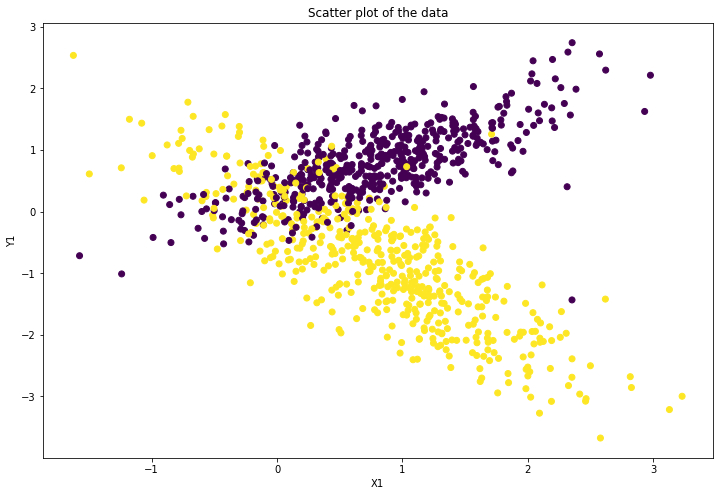

In [3]:
# Scatter plot to visualise the data
plt.figure(figsize = (12, 8))
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel('X1')
plt.ylabel('Y1')
plt.title('Scatter plot of the data')
plt.show()

In [4]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [5]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

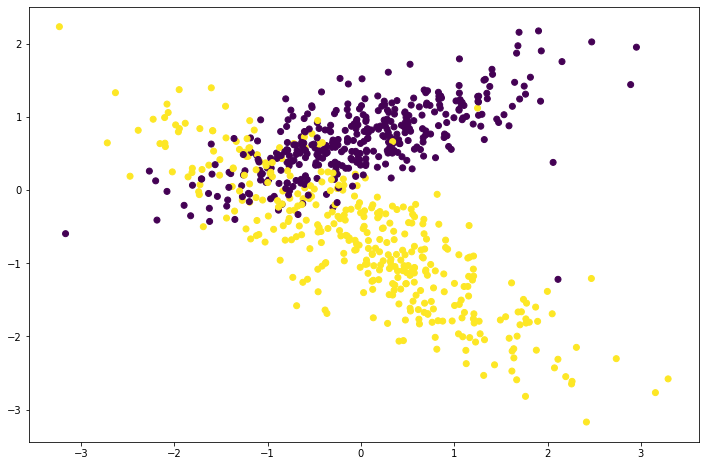

In [6]:
# Plot the scaled data (training set)
plt.figure(figsize = (12, 8))
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c = y_train)
plt.show()

In [7]:
class GDA:
    
    def __init__(self, diff_covar = False):
        '''
        Implementation of Gaussian Discriminant Algorithm for Binary Classification.
    
        parameters:
        diff_covar: Boolean (default value = False)
                    If this parameter is False, only one covariance matrix is fitted to P(x|y=0) and P(x|y=1).
                    If this parameter is True, 2 different covariance matrices are fit to the data.
        '''
        self.diff_covar = diff_covar
    
    def fit(self, X, y):
        '''
        This function / method fits parameters of Gaussian Discriminant Algorithm to training data.
    
        parameters:
        X: Feature matrix of shape (m, n)
            m = Number of training examples
            n = Number of features
        y: Target vector of shape (m, ) or (m, 1)
        
        Output:
        Following parameters of GDA are calculated and stored as instance attributes of the class.
        phi: Parameter phi, P(y) = (phi ^ y) * ((1-phi) * (1- y))
        mu_0: Mean of the gaussian distribution P(x|y=0). Shape = (n, 1)
        mu_1: Mean of the gaussian distribution P(x|y=1). Shape = (n, 1)
        If diff_covar is False, then same covariance is fitted matrix for both P(x|y=0) and P(x|y=1)
            sigma_1: Covariance matrix of gaussian distribution P(x|y=0) and P(x|y=1). Shape = (n, n)
        If self.diff_covar is True, then different covariance matrices are fitted for P(x|y=0) and P(x|y=1)
            sigma_0: Covariance matrix of gaussian distribution P(x|y=0). Shape = (n, n)
            sigma_1: Covariance matrix of gaussian distribution P(x|y=1). Shape = (n, n)
        '''        
        self.X = X
        self.y = y
        self.m = X.shape[0]
        self.n = X.shape[1]
        self.phi = np.sum(self.y) / self.m
        self.mu_0 = np.sum(np.multiply(np.where(self.y==0, 1, 0), self.X), axis = 0) / np.sum(np.where(self.y == 0, 1, 0))
        self.mu_1 = np.sum(np.multiply(self.y, self.X), axis = 0) / np.sum(self.y)
        # Reshaping mu_0 and mu_1
        self.mu_0 = self.mu_0.reshape((self.n, 1))
        self.mu_1 = self.mu_1.reshape((self.n, 1))
        # Temporary variables to calculate self.sigma
        temp_0 = 0
        temp_1 = 0
        if self.diff_covar == False:
            for i in range(self.m):
                if self.y[i][0] == 0:
                    temp_0 = temp_0 + np.matmul(self.X[i,:].reshape(-1, 1) - self.mu_0, (self.X[i, :].reshape(-1, 1) - self.mu_0).T)
                else:
                    temp_1 = temp_1 + np.matmul(self.X[i,:].reshape(-1, 1) - self.mu_1, (self.X[i, :].reshape(-1, 1) - self.mu_1).T)
            self.sigma_0 = temp_1 / self.m
            self.sigma_1 = self.sigma_0
        else:
            for i in range(self.m):
                if self.y[i][0] == 0:
                    temp_0 = temp_0 + np.matmul(self.X[i,:].reshape(-1, 1) - self.mu_0, (self.X[i, :].reshape(-1, 1) - self.mu_0).T)
                else:
                    temp_1 = temp_1 + np.matmul(self.X[i,:].reshape(-1, 1) - self.mu_1, (self.X[i, :].reshape(-1, 1) - self.mu_1).T)
            self.sigma_0 = temp_0 / np.sum(np.where(self.y == 0, 1, 0))
            self.sigma_1 = temp_1 / np.sum(self.y)
        
    def predict_example(self, x):
        '''
        This function / method performs prediction on single example.
        
        parameters:
        x: Single example of shape (n, 1)
            n = number of features
        
        Outputs: 0 / 1, predicted classification of the example based on GDA algorithm.
        
        P(y = 0|x) = P(x|y = 0) * P(y = 0) / P(x), P(x) is constant and therefore is not calculated.
        py0_x = P(x|y = 0) * P(y = 0)
        py1_x = P(x|y = 1) * P(y = 1)
        
        If py0_x > py1_x, then the example is classified as 0. Otherwise, the example is classified as 1.
        '''
        term_1 = (x - self.mu_0).reshape((self.n, 1))
        term_2 = (x - self.mu_1).reshape((self.n, 1))
        py0_x = ((2 * np.pi) ** (-self.n / 2)) * ((np.linalg.det(self.sigma_0)) ** (-0.5)) * \
        np.exp(- 0.5 * np.matmul(np.matmul(term_1.T, np.linalg.inv(self.sigma_0)), term_1)) * (1 - self.phi)
        py1_x = ((2 * np.pi) ** (-self.n / 2)) * ((np.linalg.det(self.sigma_1)) ** (-0.5)) * \
        np.exp(- 0.5 * np.matmul(np.matmul(term_2.T, np.linalg.inv(self.sigma_1)), term_2)) * self.phi
        if py0_x > py1_x:
            return 0
        else:
            return 1
        
    def predict(self, X):
        '''
        This function / method performs prediction on example matrix
        
        parameters:
        X: Feature matrix of shape (m, n)
            m = number of examples
            n = number of features
            
        Outputs:
        y_predict: Array of predictions for the examples. Shape = (m, 1)
        '''
        y_predict = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            y_predict[i] = self.predict_example(X[i, :].reshape(-1, 1))
        return y_predict
    
    def plot_contours(self):
        '''
        This function / method plots contours of gaussian distributions, decision boundary and scatter plot of the
        training data.
        This function provides visual method of understading how GDA algorithm is classifying the training examples.
        
        parameters:
        None
        
        Outputs:
        ax: Matplotlib axes object which contains the plots
        '''        
        xrange = np.linspace(self.X[:, 0].min() - 1, self.X[:, 0].max() + 1, num = 100)
        yrange = np.linspace(self.X[:, 1].min() - 1, self.X[:, 1].max() + 1, num = 100)
        # z1 = Contour of P(X|y=0)
        z1 = [[self.gaussian_calc(np.array([x, y]), self.mu_0, self.sigma_0) for x in xrange] for y in yrange]
        z1 = np.array(z1).reshape(len(xrange), len(yrange))
        # z2 = Contour of P(X|y=1)
        z2 = [[self.gaussian_calc(np.array([x, y]), self.mu_1, self.sigma_1) for x in xrange] for y in yrange]
        z2 = np.array(z2).reshape(len(xrange), len(yrange))
        # z3 = Contour of P(y=1|x) which is used to plot decision boundary
        z3 = [[self.prob_calc(np.array([x, y])) for x in xrange] for y in yrange]
        z3 = np.array(z3).reshape(len(xrange), len(yrange))
        fig, ax = plt.subplots(figsize = (12, 8))
        ax.contour(xrange, yrange, z1)
        ax.contour(xrange, yrange, z2)
        ax.contourf(xrange, yrange, z3, levels = (0, 0.5, 1))
        ax.scatter(self.X[:,0], self.X[:, 1], c = self.y)
        return ax
        
    def gaussian_calc(self, X, mu, sigma):
        '''
        This function / method calculates multivariate gaussian.
        
        parameters:
        X: X array of shape (n, 1)
        mu = Mean of the gaussian. Shape = (n, 1)
        sigma = Covariance of the gaussian. Shape = (n, n)
    
        Outputs:
        gaussian: Multivariate gaussian value (scalar)
        '''        
        X = X.reshape((self.n, 1))
        term_1 = (X - mu).reshape((self.n, 1))
        gaussian = ((2 * np.pi) ** (-self.n / 2)) * ((np.linalg.det(sigma)) ** (-0.5)) * \
        np.exp(- 0.5 * np.matmul(np.matmul(term_1.T, np.linalg.inv(sigma)), term_1))
        return gaussian
    
    def prob_calc(self, X):
        '''
        This function / method calculates P(y=1|X) for given example X.
        
        parameters:
        X: Example of shape (n, 1)
            n = Number of features
            
        Outputs:
        py1_x: P(y=1|x). Calculated using Baye's rule. Scalar.
        '''
        X = X.reshape((self.n, 1))
        term_1 = (X - self.mu_0).reshape((self.n, 1))
        term_2 = (X - self.mu_1).reshape((self.n, 1))
        px_y0 = ((2 * np.pi) ** (-self.n / 2)) * ((np.linalg.det(self.sigma_0)) ** (-0.5)) * \
        np.exp(- 0.5 * np.matmul(np.matmul(term_1.T, np.linalg.inv(self.sigma_0)), term_1))
        px_y1 = ((2 * np.pi) ** (-self.n / 2)) * ((np.linalg.det(self.sigma_1)) ** (-0.5)) * \
        np.exp(- 0.5 * np.matmul(np.matmul(term_2.T, np.linalg.inv(self.sigma_1)), term_2))
        py1_x = (px_y1 * self.phi) / (px_y1 * self.phi + px_y0 * (1 - self.phi))
        return py1_x

def accuracy_calc(y, y_pred):
    '''
    This function calculates accuracy of the classification.
        
    parameters:
    y: Target / label vector of shape (m, 1)
    y_pred: Predicted vector of shape (m, 1)
            
    Outputs:
    accuracy: accuracy of the classification in percentage.
    '''    
    accuracy = np.round(np.sum(np.where(y == y_pred, 1, 0)) / len(y), 2) * 100
    return accuracy

# Implementation of GDA with same covariance matrices
The decision boundary in this case is linear. As discussed in the lecture notes, the decision boundary will be same as that of Logistic Regression.

In [8]:
clf1 = GDA()
clf1.fit(X_train_scaled, y_train)
y_train_pred = clf1.predict(X_train_scaled)
y_test_pred = clf1.predict(X_test_scaled)
train_accuracy = accuracy_calc(y_train, y_train_pred)
test_accuracy = accuracy_calc(y_test, y_test_pred)
print('Train accuracy is: {}'.format(train_accuracy))
print('Test accuracy is: {}'.format(test_accuracy))

Train accuracy is: 84.0
Test accuracy is: 81.0


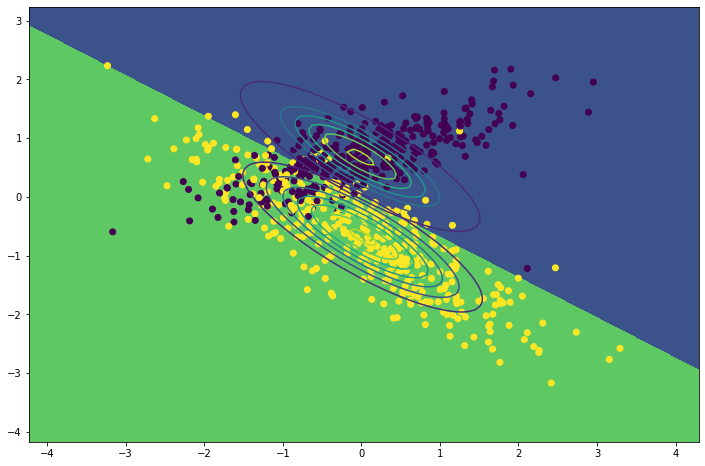

In [9]:
clf1.plot_contours()

# Implementation of GDA with different covariance matrices
The decision boundary in this case is non-linear. Accuracy of this classifier is also high because of the non-linear decision boundary.

In [10]:
clf2 = GDA(diff_covar=True)
clf2.fit(X_train_scaled, y_train)
y_train_pred = clf2.predict(X_train_scaled)
y_test_pred = clf2.predict(X_test_scaled)
train_accuracy = accuracy_calc(y_train, y_train_pred)
test_accuracy = accuracy_calc(y_test, y_test_pred)
print('Train accuracy is: {}'.format(train_accuracy))
print('Test accuracy is: {}'.format(test_accuracy))

Train accuracy is: 89.0
Test accuracy is: 92.0


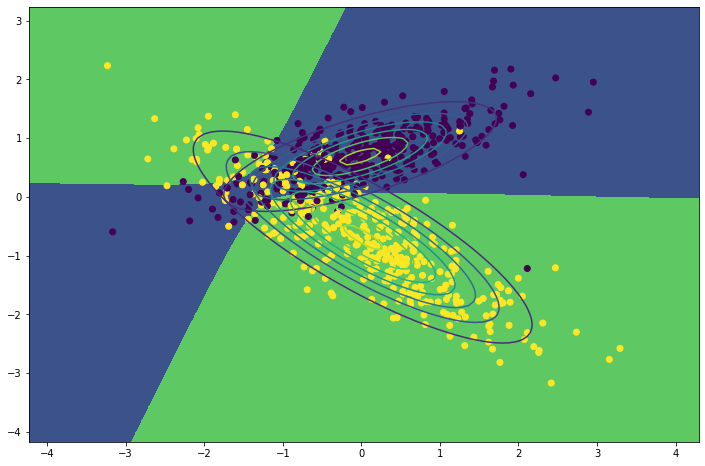

In [11]:
clf2.plot_contours()